In [1]:
import gym
import numpy as np
import cv2
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import namedtuple,deque
import torch
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# define the environment..
env = gym.make('CartPole-v1')

In [3]:
# define the network architecture....
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
    def forward(self, state):       
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# define  the Agent class

class Agent():
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(0)

        ## hyperparameters
        self.buffer_size = 2000
        self.batch_size = 64
        self.gamma = 0.99
        self.lr = 0.0025
        self.update_every = 4 

        # Q-Network
        self.local = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = deque(maxlen=self.buffer_size) 
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.t_step = 0
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append(self.experience(state, action, reward, next_state, done)) 
        # Learn every update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.sample_experiences()
                self.learn(experiences, self.gamma)
    def act(self, state, eps=0.):
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.local.eval()
            with torch.no_grad():
                action_values = self.local(state)
            self.local.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    def learn(self, experiences, gamma): 
        states, actions, rewards, next_states, dones = experiences
       # Get expected Q values from local model
        Q_expected = self.local(states).gather(1, actions)

        # Get max predicted Q values (for next states) from local model
        Q_targets_next = self.local(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def sample_experiences(self):
        experiences = random.sample(self.memory, k=self.batch_size)        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)        
        return (states, actions, rewards, next_states, dones)
agent = Agent(env.observation_space.shape[0], env.action_space.n)

In [5]:
scores = [] # list containing scores from each episode
scores_window = deque(maxlen=100) # last 100 scores
n_episodes=5000
max_t=5000
eps_start=1.0
eps_end=0.001
eps_decay=0.9995
eps = eps_start

Episode 100	Average Score: 12.80 	Epsilon: 0.951217530242334
Episode 200	Average Score: 17.46 	Epsilon: 0.9048147898403269
Episode 300	Average Score: 23.07 	Epsilon: 0.8606756897186528
Episode 400	Average Score: 26.35 	Epsilon: 0.8186898039137951
Episode 500	Average Score: 27.50 	Epsilon: 0.7787520933134615
Episode 600	Average Score: 32.12 	Epsilon: 0.7407626428726788
Episode 700	Average Score: 43.68 	Epsilon: 0.7046264116491338
Episode 800	Average Score: 41.80 	Epsilon: 0.6702529950324074
Episode 900	Average Score: 35.80 	Epsilon: 0.637556398572254
Episode 1000	Average Score: 40.82 	Epsilon: 0.606454822840097
Episode 1100	Average Score: 28.77 	Epsilon: 0.5768704587855094
Episode 1200	Average Score: 44.41 	Epsilon: 0.548729293075715
Episode 1300	Average Score: 37.83 	Epsilon: 0.5219609229311034
Episode 1400	Average Score: 19.75 	Epsilon: 0.49649837999353363
Episode 1500	Average Score: 57.93 	Epsilon: 0.4722779627867691
Episode 1600	Average Score: 48.87 	Epsilon: 0.44923907734991153
Epi

Text(0.5, 1.0, 'Scores over increasing episodes')

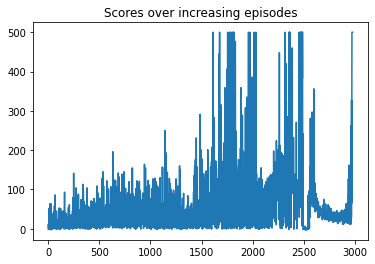

In [7]:
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    state_size = env.observation_space.shape[0]
    state = np.reshape(state,[1,state_size])
    score = 0
    for i in range(max_t):
        action = agent.act(state,eps)
        next_state , reward,done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        reward = reward if not done or score == 499 else -10
        agent.step(state,action,reward,next_state,done)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score) 
    scores.append(score) 
    eps = max(eps_end, eps_decay*eps) 
    print('\rEpisode {}\tReward {} \tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode,score,np.mean(scores_window), eps), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, np.mean(scores_window), eps))
    if i_episode>10 and np.mean(scores[-10:])>450:
        break
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(scores)
plt.title('Scores over increasing episodes')